------------------------------------------------------------------------------------------------------------------------------------------------------

## CALIBRATION NOTEBOOK


##### PLEASE! When you are done with the tutorial, move to the ```notebooks``` folder to start your own analysis 
 In this way, you will be able to keep the tutorial as a reference for future use (or others to use it).

------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import sys; sys.path.insert(0, '../'); from lib import *;
figure_features()

You don't have latex installed. Changing default configuration to tex=Foptionalalse


In [69]:
# Set options for general visualitation
OPT  = {
    "MICRO_SEC":   True,                # Time in microseconds (True/False)
    "NORM":        False,               # Runs can be displayed normalised (True/False)
    "ALIGN":       True,                # Aligns waveforms in peaktime (True/False)
    "LOGY":        False,               # Runs can be displayed in logy (True/False)
    "SHOW_AVE":    "",                  # If computed, vis will show average (AveWvf,AveWvfSPE,etc.)
    "SHOW_PARAM":  False,               # Print terminal information (True/False)
    "CHARGE_KEY":  "ChargeAveRange",    # Select charge info to be displayed. Default: "ChargeAveRange" (if computed)
    "PEAK_FINDER": False,               # Finds possible peaks in the window (True/False)
    "LEGEND":      True,                # Shows plot legend (True/False)
    "SHOW":        False,
    "THRESHOLD":  1,
    "WIDTH":      15,
    "PROMINENCE": 0.5,
    "ACCURACY":   500,
    "TERMINAL_MODE": False
    }

In [51]:
INPUT_FILE = "Feb22_2"; OV = 1; PRESET ="EVA"
info = read_input_file(INPUT_FILE)  # Read input file
channels = [0,6]

#-------------------------------- LOAD RUNS ---------------------------------#
run_keys = ["CALIB_RUNS"]
nruns = dict.fromkeys(run_keys)
for key in run_keys:
    try:               nruns[key] = info[key][OV] # Store runs in dictionary
    except IndexError: nruns.pop(key)
print(nruns)

runs = dict.fromkeys(nruns.keys())
for run in runs: runs[run] = load_npy(np.asarray([nruns[run]]).astype(int),np.asarray(channels).astype(int),preset=PRESET,info=info,compressed=True)
#----------------------------------------------------------------------------#

{'CALIB_RUNS': 2}
load_npy --> DONE!

load_npy --> DONE!



## BEFORE DECONVOLUTION


In [61]:
params = {"THRESHOLD": 10, "WIDTH": 15, "PROMINENCE": 0.5, "ACCURACY": 500, "FIT": "gaussian"}
new_params = {}
for i,param in enumerate(params.keys()):
    if check_key(OPT,param) == True: new_params[param] = OPT[param]
    else:                            new_params[param] = params[param]

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


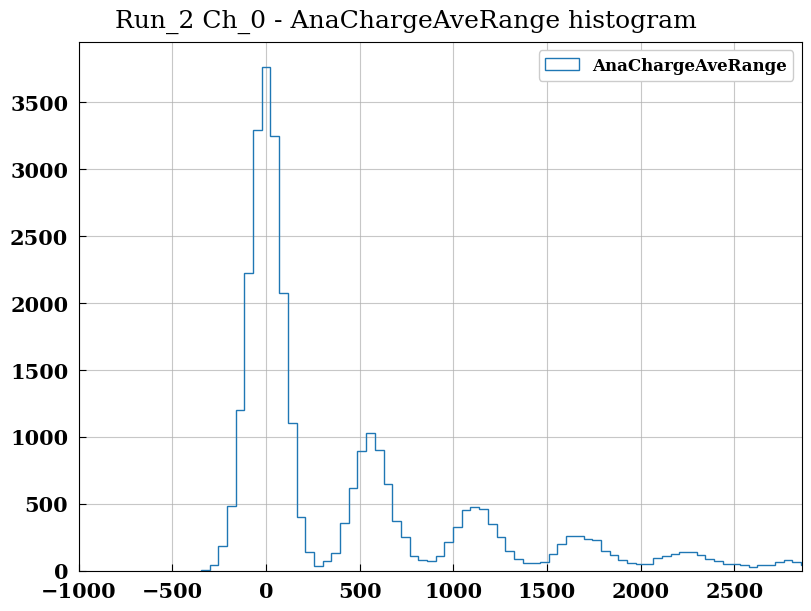

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


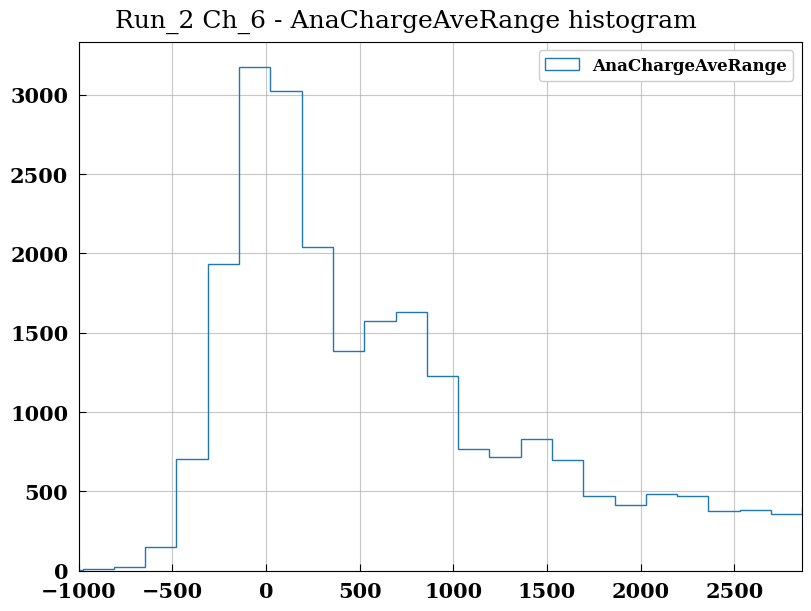

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


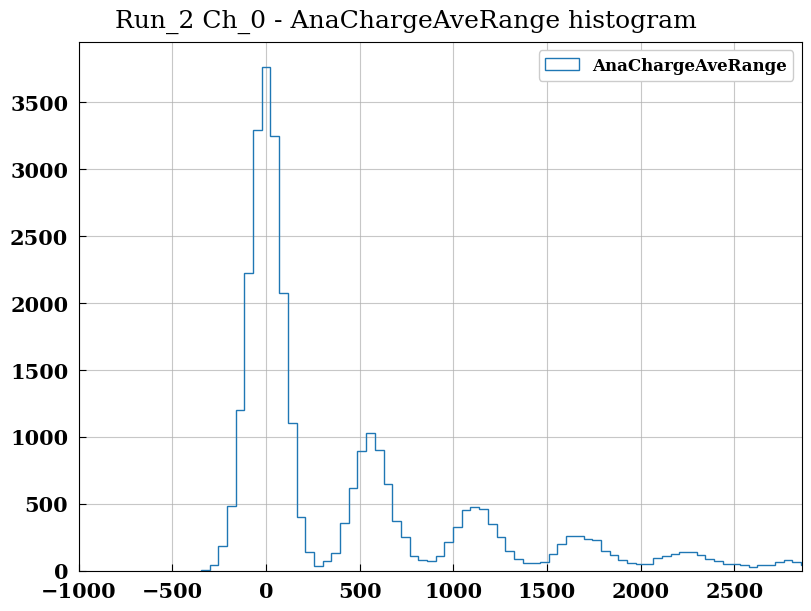

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


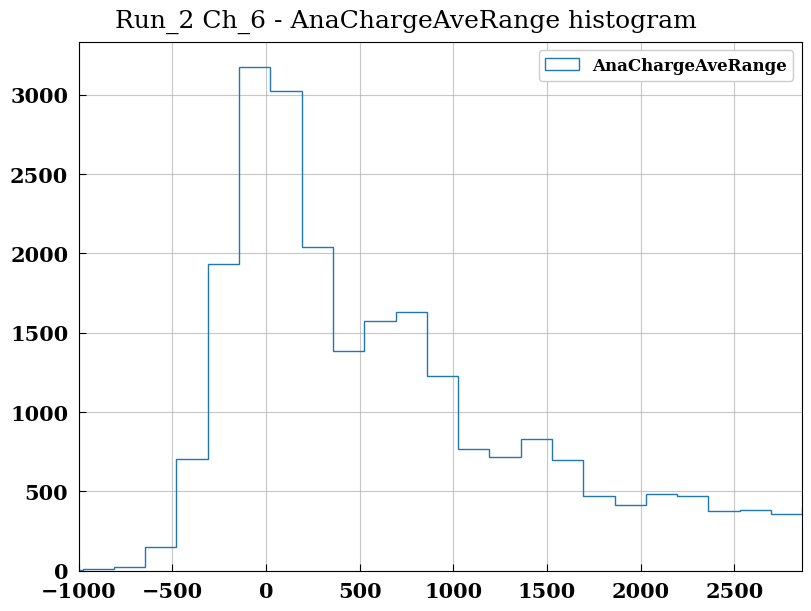

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


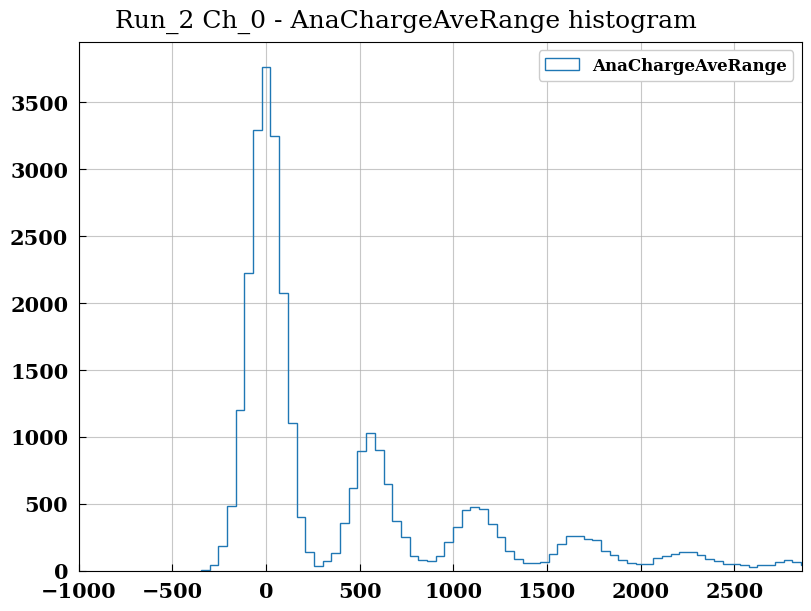

(array([], dtype=int64), {'peak_heights': array([], dtype=float64), 'prominences': array([], dtype=float64), 'left_bases': array([], dtype=int64), 'right_bases': array([], dtype=int64), 'widths': array([], dtype=float64), 'width_heights': array([], dtype=float64), 'left_ips': array([], dtype=float64), 'right_ips': array([], dtype=float64)})


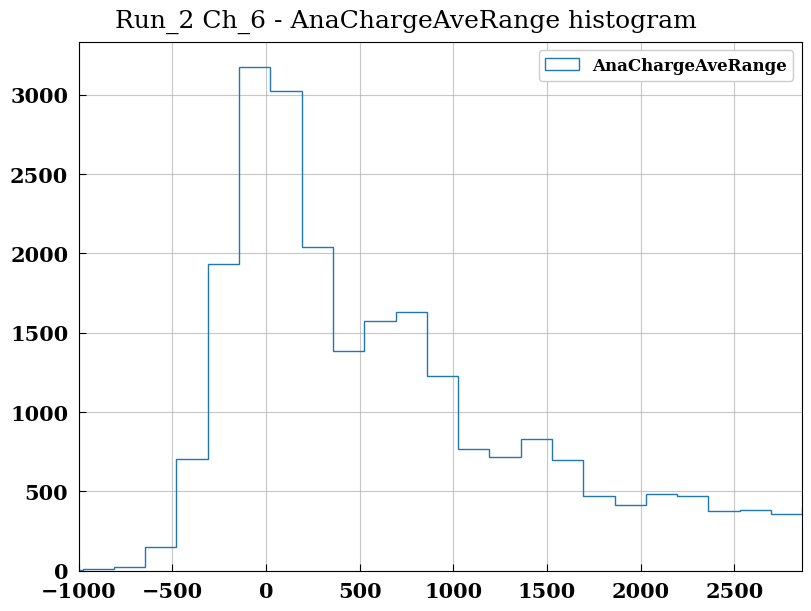

In [70]:
keys = ["AnaChargeAveRange"]; 
density = OPT["NORM"]
binning = OPT["ACCURACY"]
debug = True

for r,run in enumerate(runs["CALIB_RUNS"]):
    for c,ch in enumerate(channels):
        fig_cal, ax_cal = plt.subplots(1,1, figsize = (8,6)); add_grid(ax_cal)
        for key in keys: 
            counts, bins, bars = ax_cal.hist(runs["CALIB_RUNS"][runs["CALIB_RUNS"]["NRun"][0]][ch][key],bins = int(binning),histtype="step", label=key, density=density);
            
            peaks=find_peaks(counts,height=new_params["THRESHOLD"],width=new_params["WIDTH"]) #,width=my_sigma[c]
            print(peaks)
            ax_cal.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x") #a Rodrigo le gustan las x para los picos jaja
            
            # x, y, peak_idx, valley_idx, popt, pcov, perr = gaussian_train_fit(counts, bins, bars, new_params, debug=debug)
            # ax_cal.axhline(params["THRESHOLD"], ls='--')
            # # ax_cal.plot(x[peak_idx], y[peak_idx], 'r.', lw=4)
            # ax_cal.plot(x[valley_idx], y[valley_idx], 'b.', lw=6)
            # ax_cal.plot(x,gaussian_train(x, *popt),color="red", ls='--', linewidth=1,label="Best fit")

        # plt.semilogy()
        plt.xlim([-1e3,x[peak_idx[-1]]*5])
        fig_cal.suptitle("Run_{} Ch_{} - {} histogram".format(runs["CALIB_RUNS"]["NRun"][0],ch,key))
        # fig_cal.supxlabel(key+" ("+runs["CALIB_RUNS"][runs["CALIB_RUNS"]["NRun"][0]][ch]["UnitsDict"][key]+")"); fig_cal.supylabel("Counts")
        plt.legend()
        plt.show()

In [ ]:
popt, pcov, perr = calibrate(runs["CALIB_RUNS"], ["AnaChargeAveRange"], OPT=OPT, debug=False) #TO solve: not repeated plots

## AFTER DECONVOLUTION

In [ ]:
for c, ch in enumerate(channels):
    fast =np.sum(runs["CALIB_RUNS"][runs["CALIB_RUNS"]["NRun"][0]][ch]["DecADC"][:,500:1000],axis=1)
    total=np.sum(runs["CALIB_RUNS"][runs["CALIB_RUNS"]["NRun"][0]][ch]["DecADC"][:,500:3000],axis=1)

    plt.plot(total,fast/total,',')
    plt.ylim([0,1])
    plt.xlim([0,1000])
    CUT=(fast>0.7)*(total>130)
    plt.hist(total[CUT],200,[100,1000]);
    plt.semilogy()
    plt.grid()
    plt.show()

In [ ]:
# With cuts
f90 = fast/total
CUT_total = total>100
CUT_tf90  = f90>0.6
CUT = CUT_tf90*CUT_total

plt.figure(dpi=200)
Amp=np.max(runs["CALIB_RUNS"][runs["CALIB_RUNS"]["NRun"][0]][ch]["DecADC"],axis=1)
plt.plot(total[~CUT], Amp[~CUT], ",");
plt.plot(total[CUT] , Amp[CUT] , ",");
plt.xlim([0,1000])
plt.ylabel("Amp [Arb units]")
plt.xlabel("Charge [Arb units]")
x_ticks=np.arange(0,1000,1)
plt.plot(x_ticks,0.01*x_ticks)
plt.show()

## GAIN FIT

STORED GAINS ->  {0: [410.80262272211183, 404.4927197412551, 405.7285245504968, 414.6751422246748, -99.0], 6: [-99.0]}
STORED DGAIN ->  {0: [0.8091375331179175, 1.8507450960835337, 4.071357427213988, 8.00219503325073, -99.0], 6: [-99.0]}
Channel 0: G = 1.29 * OV + 403.14
No valid gains for channel 6


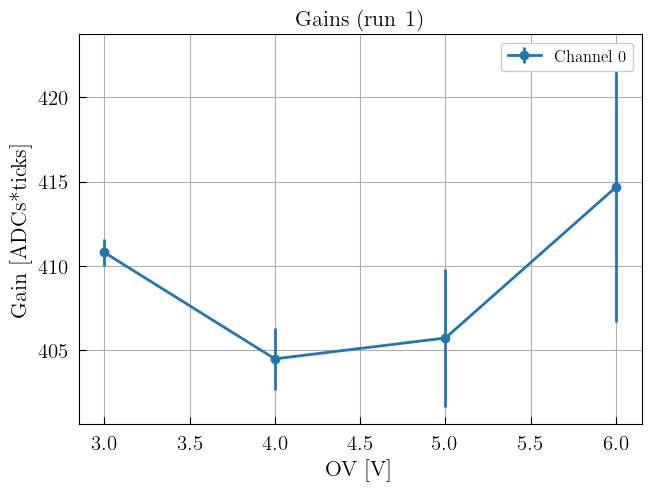

In [10]:
folder_path = "TUTORIAL"
channels    = [0,6];      run   = 1
my_ov       = [[3,4,5,6],[3]]; debug = False

gains, Dgain = get_gains(run,channels,folder_path=folder_path,debug=debug)
print("STORED GAINS -> ",gains)
print("STORED DGAIN -> ",Dgain)

for c,ch in enumerate(channels):
    filter_gains = np.array(gains[ch])[np.array(gains[ch])!=-99]
    filter_Dgain = np.array(Dgain[ch])[np.array(Dgain[ch])!=-99]
    if filter_gains.size == 0:
        print("No valid gains for channel %i"%ch)
        continue
    a, b = np.polyfit(my_ov[c], filter_gains, 1)
    print("Channel %i: G = %.2f * OV + %.2f"%(ch,a,b))
    plt.errorbar(my_ov[c], filter_gains, yerr=filter_Dgain, label="Channel "+str(ch), marker = "o")

plt.xlabel("OV [V]"); plt.ylabel("Gain [ADCs*ticks]"); plt.title("Gains (run %i)"%run)
plt.grid(True)
plt.legend()
plt.show()
# plt.savefig("gain_fit_SiPMs.png", dpi = 400)